# Saving and Loading Models

In this notebook, I'll show you how to save and load models with PyTorch. This is important because you'll often want to load previously trained models to use in making predictions or to continue training on new data.

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms

import sys
sys.path.insert(0, '../answers')
import helper
import fc_model

In [3]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

Here we can see one of the images.

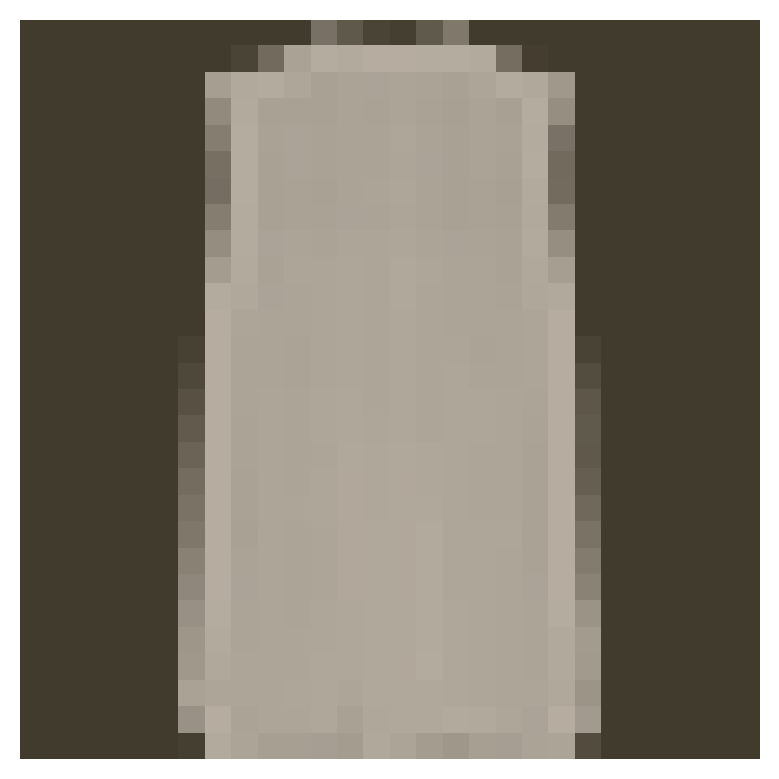

In [4]:
image, label = next(iter(trainloader))
helper.imshow(image[0,:]);

# Train a network

To make things more concise here, I moved the model architecture and training code from the last part to a file called `fc_model`. Importing this, we can easily create a fully-connected network with `fc_model.Network`, and train the network using `fc_model.train`. I'll use this model (once it's trained) to demonstrate how we can save and load models.

In [5]:
# Create the network, define the criterion and optimizer

model = fc_model.Network(784, 10, [512, 256, 128])
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [6]:
fc_model.train(model, trainloader, testloader, criterion, optimizer, epochs=2)

Epoch: 1/2..  Training Loss: 1.609..  Test Loss: 0.928..  Test Accuracy: 0.643
Epoch: 1/2..  Training Loss: 1.046..  Test Loss: 0.739..  Test Accuracy: 0.714
Epoch: 1/2..  Training Loss: 0.869..  Test Loss: 0.685..  Test Accuracy: 0.748
Epoch: 1/2..  Training Loss: 0.786..  Test Loss: 0.633..  Test Accuracy: 0.751
Epoch: 1/2..  Training Loss: 0.741..  Test Loss: 0.609..  Test Accuracy: 0.766
Epoch: 1/2..  Training Loss: 0.688..  Test Loss: 0.607..  Test Accuracy: 0.771
Epoch: 1/2..  Training Loss: 0.712..  Test Loss: 0.570..  Test Accuracy: 0.786
Epoch: 1/2..  Training Loss: 0.717..  Test Loss: 0.581..  Test Accuracy: 0.777
Epoch: 1/2..  Training Loss: 0.661..  Test Loss: 0.553..  Test Accuracy: 0.797
Epoch: 1/2..  Training Loss: 0.667..  Test Loss: 0.565..  Test Accuracy: 0.787
Epoch: 1/2..  Training Loss: 0.677..  Test Loss: 0.563..  Test Accuracy: 0.796
Epoch: 1/2..  Training Loss: 0.633..  Test Loss: 0.528..  Test Accuracy: 0.801
Epoch: 1/2..  Training Loss: 0.629..  Test Loss: 0.5

## Saving and loading networks

As you can imagine, it's impractical to train a network every time you need to use it. Instead, we can save trained networks then load them later to train more or use them for predictions.

The parameters for PyTorch networks are stored in a model's `state_dict`. We can see the state dict contains the weight and bias matrices for each of our layers.

**Note.** You can read here, why we are using `state_dict` when saving the model:
https://pytorch.org/tutorials/beginner/saving_loading_models.html

In [7]:
print("Our model: \n\n", model, '\n')
print("The state dict keys: \n\n", model.state_dict().keys())

Our model: 

 Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
  )
  (output): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
) 

The state dict keys: 

 odict_keys(['hidden_layers.0.weight', 'hidden_layers.0.bias', 'hidden_layers.1.weight', 'hidden_layers.1.bias', 'hidden_layers.2.weight', 'hidden_layers.2.bias', 'output.weight', 'output.bias'])


The simplest thing to do is simply save the state dict with `torch.save`. For example, we can save it to a file `'network_A.pth'`.

In [8]:
torch.save(model.state_dict(), 'network_A.pth')

Then we can load the state dict with `torch.load`.

In [9]:
state_dict = torch.load('network_A.pth')
print(state_dict.keys())

odict_keys(['hidden_layers.0.weight', 'hidden_layers.0.bias', 'hidden_layers.1.weight', 'hidden_layers.1.bias', 'hidden_layers.2.weight', 'hidden_layers.2.bias', 'output.weight', 'output.bias'])


And to load the state dict in to the network, you do `model.load_state_dict(state_dict)`.

In [10]:
model.load_state_dict(state_dict)

<All keys matched successfully>

Seems pretty straightforward, but as usual it's a bit more complicated. Loading the state dict works only if the model architecture is exactly the same as the checkpoint architecture. If I create a model with a different architecture, this fails.

***
### Exercise: 
This code will throw an error because the tensor sizes are wrong! Correct it.
```python
# Code that throws an error
loaded_model = fc_model.Network(784, 10, [400, 200, 100])
loaded_model.load_state_dict(state_dict)
```

In [11]:
## Task 1:
## Your code here 
loaded_model = fc_model.Network(784, 10, [400, 200, 100])
loaded_model.load_state_dict(loaded_model.state_dict())

<All keys matched successfully>

***
This means we need to rebuild the model exactly as it was when trained. Information about the model architecture needs to be saved in the checkpoint, along with the state dict. To do this, you build a dictionary with all the information you need to compeletely rebuild the model.

In [12]:
checkpoint = {'input_size': 784,
              'output_size': 10,
              'hidden_layers': [each.out_features for each in model.hidden_layers],
              'state_dict': model.state_dict()}

torch.save(checkpoint, 'network_B.pth')

Now the checkpoint has all the necessary information to rebuild the trained model. You can easily make that a function if you want. Similarly, we can write a function to load checkpoints. 

In [13]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = fc_model.Network(checkpoint['input_size'],
                             checkpoint['output_size'],
                             checkpoint['hidden_layers'])
    model.load_state_dict(checkpoint['state_dict'])
    
    return model

***
### Exercise: 
Save model using checkpoint method with filename `example_network.pth`.

In [14]:
## Task 2:
## Your code here 
torch.save(checkpoint,'example_network.pth')
 

***
### Exercise: 
Import saved `example_network.pth` to variable `reloaded_model` and print network model.

In [15]:
## Task 3:
## Your code here 
reloaded_model = load_checkpoint('example_network.pth')
print("model",reloaded_model)

model Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
  )
  (output): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


***
### Exercise: 
Test `reloaded_model` by 
1. Calculate test loss and test accuracy with test dataset.
2. Print 1 example image with class probabilities.

**Note.** Use `model.eval()`to prevent dropout to work during inference.

In [16]:
## Task 4:
## Your code here
reloaded_model.eval()
test_loss = 0
test_accuracy = 0

criterion = nn.NLLLoss()

with torch.no_grad():
    for img, labels in testloader:
        img = img.view(img.shape[0],-1)
        log_ps = reloaded_model(img)
        test_loss += criterion(log_ps,labels)
        
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1,dim=1)
        equals = top_class == labels.view(*top_class.shape)
        test_accuracy += torch.mean(equals.type(torch.FloatTensor))

test_loss /= len(testloader)
test_accuracy /= len(testloader)

In [17]:
print("Test Loss: {:.3f}.. ".format(test_loss),
        "Test Accuracy: {:.3f}".format(test_accuracy))

Test Loss: 0.455..  Test Accuracy: 0.836


Label: 4


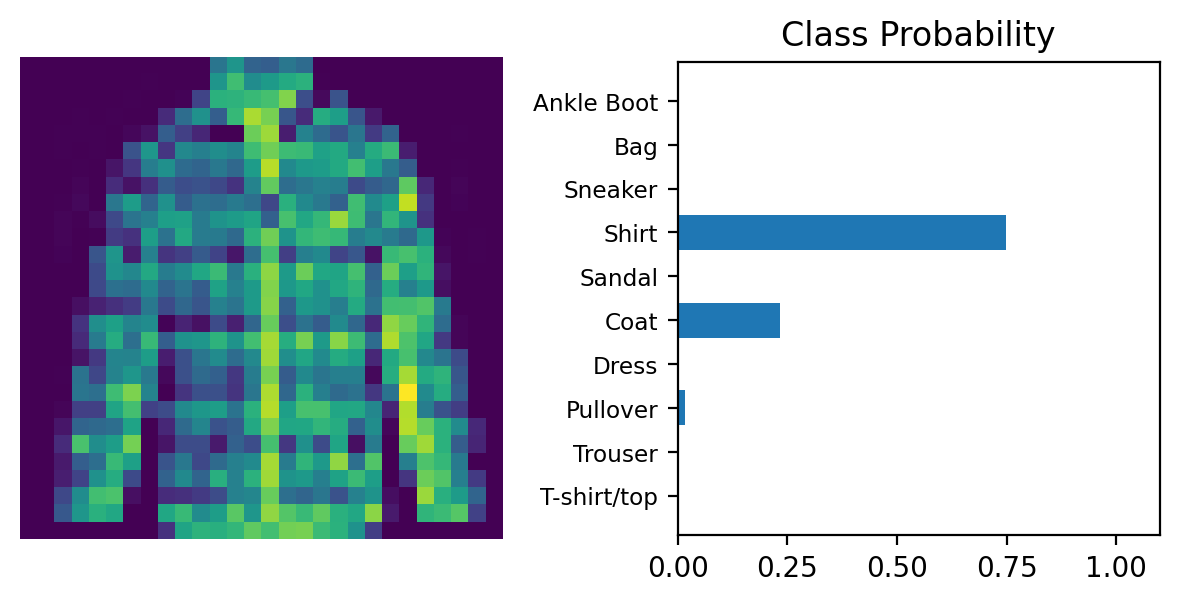

In [18]:
## Task 5:
## Your code here

dataiter = iter(testloader)
images, labels = next(dataiter)
img = images[0]

example_label = labels[0].item()

img = img.view(1, 784)

with torch.no_grad():
    output = reloaded_model.forward(img)

example_probabilities = torch.exp(output)

helper.view_classify(img.view(1, 28, 28), example_probabilities, version='Fashion')

print('Label:', example_label)


***
## Reflection

Answer briefly following questions (in English or Finnish):
- What is ONNX?



## ONNX
*Open neural network exchange*
Tämän avulla pystyy esimerkiksi vaihtamaan pytorchilla koulutetut neuroverkot tensorflow:n neuroverkkoihin. 
ONNX:n avulla siis pystyy "kääntämään" ml malleja muihin ml frameworkkeihin, ja jatkamaan kehitystä toisella esimerkiksi.

Tämä auttaa yhteensopivuudessa, sekä uudelleenkäytössä. Mutta heidän sanoin, "performance is not a goal".

Heidän tavoite on luoda kirjasto/sovellus, jonka avulla voi vaihtaa syväoppimismalleja eri frameworkkien välillä. Sekä mahdollistaa neuroverkojen tallentaminen ja jakaminen yhteisellä standardilla.

### Check your answers by running following cell:

In [19]:
# Do not change this code!

import sys
sys.path.insert(0, '../answers/part6/')
from part6_check import *

print("Reloaded model:")
print(reloaded_model)

print("\nTest results:")
test_result_check(test_loss, test_accuracy)

print("\nExample:")
print("Label: ", example_label)
print("Probabilities: ", example_probabilities)
print("Check correct label: ", example_probabilities[:, example_label])


Reloaded model:
Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
  )
  (output): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

Test results:
Loss:  tensor(0.4553)
Accuracy:  tensor(0.8358)

Test results are ok!

Example:
Label:  4
Probabilities:  tensor([[1.5573e-04, 1.6137e-06, 1.7389e-02, 2.9976e-04, 2.3416e-01, 3.2047e-06,
         7.4788e-01, 1.4465e-07, 1.1061e-04, 2.5794e-08]])
Check correct label:  tensor([0.2342])


### Great work!